## Setup Datasets
1. image_batch['image'] - cuda:0
2. image_batch['image_idx'] - cuda:0

In [1]:
import src.dataloader
import torch
import pathlib

device = torch.device("cuda")

dataloader = src.dataloader.load_train_data(
    dataset_dir=pathlib.Path("C:/Users/imeho/Documents/DataSets/InstantPINF/ScalarReal"),
    split="train",
    device=device,
    frame_skip=1,
    # exclude_batch_keys_from_device=["image", "image_idx"],
    exclude_batch_keys_from_device=[],
)
image_batch = next(iter(dataloader))

print(f'image device: {image_batch["image"].device}')
print(f'image indices: {image_batch["image_idx"].device}')
memory_image = image_batch['image'].element_size() * image_batch['image'].numel()
memory_indices = image_batch['image_idx'].element_size() * image_batch['image_idx'].numel()
print(f'Memory of image: {memory_image / 1024 / 1024:.2f} MB')
print(f'Memory of indices: {memory_indices / 1024 / 1024:.2f} MB')

Caching all 480 images.

Output()

image device: cuda:0
image indices: cuda:0
Memory of image: 11390.62 MB
Memory of indices: 0.00 MB


## Setup Hash Encoder
1. xyzt_encoder(xyzt)

In [2]:
import src.encoder
import taichi as ti
import numpy as np

ti.init(arch=ti.cuda)
xyzt_encoder = src.encoder.HashEncoderHyFluid(
    min_res=np.array([16, 16, 16, 16]),
    max_res=np.array([256, 256, 256, 128]),
    num_scales=16,
    max_params=2 ** 19,
)
xyzt_encoder.to(device)

[Taichi] version 1.7.2, llvm 15.0.1, commit 0131dce9, win, python 3.11.0
[Taichi] Starting on arch=cuda


HashEncoderHyFluid()

## Setup Model & Optimizer
1. mlp(xyzt_encoded)
2. learned_rgb
3. optimizer

In [3]:
import nerfstudio.field_components.mlp
import src.radam

mlp = nerfstudio.field_components.mlp.MLP(
    in_dim=xyzt_encoder.num_scales * xyzt_encoder.features_per_level,
    num_layers=2,
    layer_width=64,
    out_dim=1,
    out_activation=torch.nn.ReLU(),
).to(device)
learned_rgb = torch.nn.Parameter(torch.tensor([0.0], device=device))

grad_vars = list(mlp.parameters()) + [learned_rgb]
embedding_params = list(xyzt_encoder.parameters())

optimizer = src.radam.RAdam([
    {'params': grad_vars, 'weight_decay': 1e-6},
    {'params': embedding_params, 'eps': 1e-15}
], lr=0.01, betas=(0.9, 0.99))

## Setup Ray Sampler & Collider

In [4]:
import nerfstudio.model_components.ray_generators
import nerfstudio.model_components.ray_samplers
import nerfstudio.data.pixel_samplers
import nerfstudio.model_components.scene_colliders

pixel_sampler = nerfstudio.data.pixel_samplers.PixelSamplerConfig(num_rays_per_batch=1024).setup()
ray_generator = nerfstudio.model_components.ray_generators.RayGenerator(dataloader.dataset.cameras).to(device)
uniform_sampler = nerfstudio.model_components.ray_samplers.UniformSampler(num_samples=192).to(device)
near_far_collider = nerfstudio.model_components.scene_colliders.NearFarCollider(near_plane=1.1, far_plane=1.5).to(
    device)

## Optimization Loop

100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


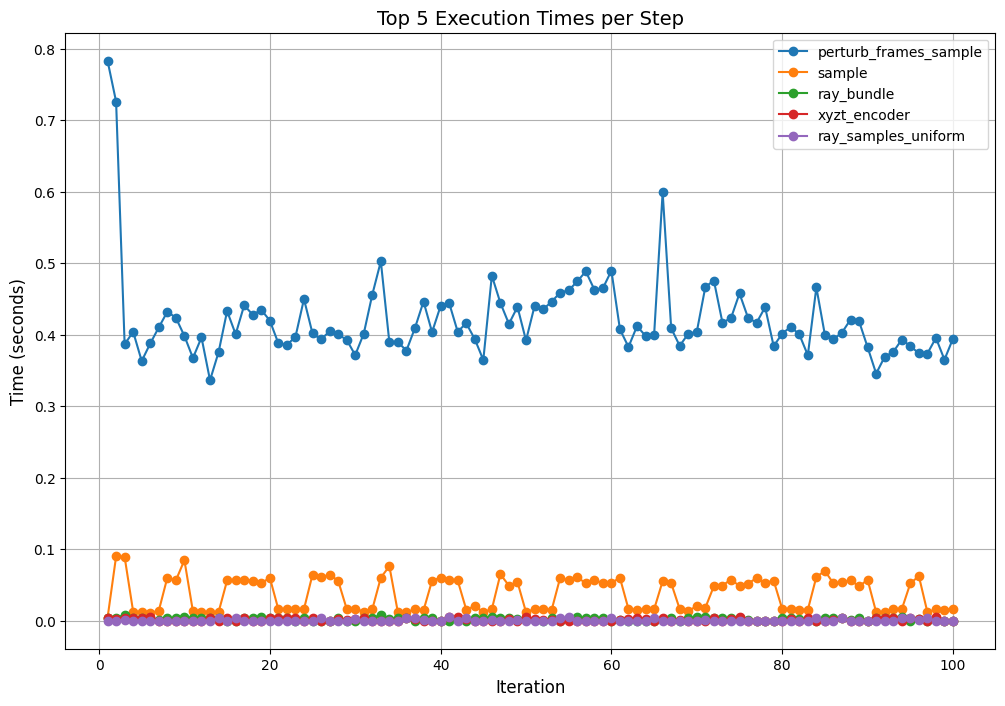

In [27]:
import time
import matplotlib.pyplot as plt
import tqdm
from collections import defaultdict


def perturb_frames_sample(image_batch, all_frames, batch):
    sample_image = batch['image']
    sample_idx = batch['indices'].float()

    video_starts = [0] + list(torch.cumsum(torch.tensor(all_frames[:-1]), dim=0).numpy())
    video_ends = [start + frames - 1 for start, frames in zip(video_starts, all_frames)]

    images = image_batch['image']
    image_idx = image_batch['image_idx']
    num_samples = sample_image.shape[0]

    for i in range(num_samples):
        current_frame_idx = int(sample_idx[i, 0].item())

        # 检查是否为视频的第一个或最后一个帧
        is_first_or_last_frame = any(
            current_frame_idx == video_starts[j] or current_frame_idx == video_ends[j]
            for j in range(len(all_frames))
        )
        if is_first_or_last_frame:
            continue

        current_height_idx = int(sample_idx[i, 1].item())
        current_width_idx = int(sample_idx[i, 2].item())
        perturb_value = (torch.rand(1).item() - 0.5)

        if perturb_value > 0:
            # 获取下一帧的索引
            next_frame_idx = torch.where(image_idx == (current_frame_idx + 1))[0].item()
            assert image_idx[next_frame_idx] == (current_frame_idx + 1)
            weight_curr = (0.5 - perturb_value) / 0.5
            weight_next = perturb_value / 0.5
            sample_image[i] = weight_curr * sample_image[i] + weight_next * images[
                next_frame_idx, current_height_idx, current_width_idx]
            sample_idx[i, 0] = current_frame_idx + perturb_value

        elif perturb_value < 0:
            # 获取前一帧的索引
            prev_frame_idx = torch.where(image_idx == (current_frame_idx - 1))[0].item()
            assert image_idx[prev_frame_idx] == (current_frame_idx - 1)
            weight_curr = (0.5 + perturb_value) / 0.5
            weight_prev = -perturb_value / 0.5
            sample_image[i] = weight_curr * sample_image[i] + weight_prev * images[
                prev_frame_idx, current_height_idx, current_width_idx]
            sample_idx[i, 0] = current_frame_idx + perturb_value

    batch['image'] = sample_image
    batch['indices'] = sample_idx


# 定义一个字典存储每句代码的执行时间
execution_times = defaultdict(list)

# 模拟循环任务
for i in tqdm.tqdm(range(100)):
    # 记录每一步的执行时间
    start = time.time()
    batch = pixel_sampler.sample(image_batch)
    execution_times["sample"].append(time.time() - start)

    start = time.time()
    ray_bundle = near_far_collider(ray_generator(batch['indices']))
    execution_times["ray_bundle"].append(time.time() - start)

    start = time.time()
    ray_samples_uniform = uniform_sampler(ray_bundle)
    execution_times["ray_samples_uniform"].append(time.time() - start)

    start = time.time()
    positions = ray_samples_uniform.frustums.get_positions()
    execution_times["get_positions"].append(time.time() - start)

    start = time.time()
    frames = batch['indices'][..., 0] % 120
    execution_times["frames_mod"].append(time.time() - start)

    start = time.time()
    perturb_frames_sample(image_batch, dataloader.dataset.metadata['all_frames'], batch)
    execution_times["perturb_frames_sample"].append(time.time() - start)

    start = time.time()
    frames_expanded = frames.unsqueeze(1).unsqueeze(2).expand(-1, positions.shape[1], -1)
    execution_times["frames_expand"].append(time.time() - start)

    start = time.time()
    xyzt = torch.cat([positions, frames_expanded], dim=-1)
    execution_times["concat"].append(time.time() - start)

    start = time.time()
    xyzt_flat = xyzt.reshape(-1, 4)
    execution_times["reshape"].append(time.time() - start)

    start = time.time()
    xyzt_encoded = xyzt_encoder(xyzt_flat)
    execution_times["xyzt_encoder"].append(time.time() - start)

    start = time.time()
    raw_flat = mlp(xyzt_encoded)
    execution_times["mlp"].append(time.time() - start)

    start = time.time()
    raw = raw_flat.reshape(xyzt.shape[0], xyzt.shape[1], raw_flat.shape[-1])
    execution_times["raw_reshape"].append(time.time() - start)

    start = time.time()
    dists = ray_samples_uniform.deltas
    execution_times["deltas"].append(time.time() - start)

# 计算平均耗时并排序
avg_execution_times = {key: sum(times) / len(times) for key, times in execution_times.items()}
sorted_avg_times = sorted(avg_execution_times.items(), key=lambda x: x[1], reverse=True)

# 获取平均耗时 Top 5 的步骤
top5_keys = [item[0] for item in sorted_avg_times[:5]]

# 绘制折线图
plt.figure(figsize=(12, 8))
for key in top5_keys:
    plt.plot(range(1, len(execution_times[key]) + 1), execution_times[key], label=key, marker='o')

# 设置图表标题和轴标签
plt.title("Top 5 Execution Times per Step", fontsize=14)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Time (seconds)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()